In [1]:
import shutil
import numpy as np 
from sklearn import svm
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import tensorflow as tf
from google.colab.patches import cv2_imshow
import cv2
import glob
import os 
np.random.seed(220)

In [9]:
# ! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
# load datasets from kaggle
! kaggle datasets download "ashwingupta3012/human-faces"
! kaggle datasets download "prasunroy/natural-images"

! unzip natural-images.zip
! unzip human-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: Humans/1 (2910).jpg     
  inflating: Humans/1 (2911).jpg     
  inflating: Humans/1 (2912).jpg     
  inflating: Humans/1 (2913).jpg     
  inflating: Humans/1 (2914).jpg     
  inflating: Humans/1 (2915).jpg     
  inflating: Humans/1 (2916).jpg     
  inflating: Humans/1 (2917).jpg     
  inflating: Humans/1 (2918).jpg     
  inflating: Humans/1 (2919).jpg     
  inflating: Humans/1 (292).jpg      
  inflating: Humans/1 (2920).jpg     
  inflating: Humans/1 (2921).jpg     
  inflating: Humans/1 (2922).jpg     
  inflating: Humans/1 (2923).jpg     
  inflating: Humans/1 (2924).jpg     
  inflating: Humans/1 (2925).jpg     
  inflating: Humans/1 (2926).jpg     
  inflating: Humans/1 (2927).jpg     
  inflating: Humans/1 (2928).jpg     
  inflating: Humans/1 (2929).jpg     
  inflating: Humans/1 (293).jpg      
  inflating: Humans/1 (2930).jpg     
  inflating: Humans/1 (2931).jpg     
  inflating: Humans/1 (2932).jpg     

In [11]:
# remove person folder to remove images that contain faces from dataset 
shutil.rmtree('/content/natural_images/person')

In [12]:
# create dataset directory
!mkdir Dataset
!mkdir Dataset/train
!mkdir Dataset/train/non_face
!mkdir Dataset/train/face
!mkdir Dataset/test
!mkdir Dataset/test/non_face
!mkdir Dataset/test/face

In [13]:
# move faces to directory
!mv Humans/*.png Dataset/train/face
!mv Humans/*.jpg Dataset/train/face
!rm -R Humans

In [14]:
#move non-faces to directory
!mv natural_images/cat/*.png Dataset/train/non_face
!mv natural_images/cat/*.jpg Dataset/train/non_face
!mv natural_images/car/*.png Dataset/train/non_face
!mv natural_images/car/*.jpg Dataset/train/non_face
!mv natural_images/dog/*.png Dataset/train/non_face
!mv natural_images/dog/*.jpg Dataset/train/non_face
!mv natural_images/flower/*.png Dataset/train/non_face
!mv natural_images/flower/*.jpg Dataset/train/non_face
!mv natural_images/fruit/*.png Dataset/train/non_face
!mv natural_images/fruit/*.jpg Dataset/train/non_face
!mv natural_images/motorbike/*.png Dataset/train/non_face
!mv natural_images/motorbike/*.jpg Dataset/train/non_face
!mv natural_images/airplane/*.png Dataset/train/non_face
!mv natural_images/airplane/*.jpg Dataset/train/non_face
!rm -R natural_images

mv: cannot stat 'natural_images/cat/*.png': No such file or directory
mv: cannot stat 'natural_images/car/*.png': No such file or directory
mv: cannot stat 'natural_images/dog/*.png': No such file or directory
mv: cannot stat 'natural_images/flower/*.png': No such file or directory
mv: cannot stat 'natural_images/fruit/*.png': No such file or directory
mv: cannot stat 'natural_images/motorbike/*.png': No such file or directory
mv: cannot stat 'natural_images/airplane/*.png': No such file or directory


In [15]:
# move files to dataset directory
ls = os.listdir('Dataset/train/face')
len(ls)
idx1 = np.random.choice(range(len(ls)),size = int(len(ls)*0.2),replace= False)
for id in idx1:   
  shutil.move(f'Dataset/train/face/{ls[id]}',f'Dataset/test/face/' )


ls2 = os.listdir('Dataset/train/non_face')
len(ls2)
idx2 = np.random.choice(range(len(ls2)),size = int(len(ls2)*0.2),replace= False)
for id in idx2:   
  shutil.move(f'Dataset/train/non_face/{ls2[id]}',f'Dataset/test/non_face/' )


In [16]:
def get_integralimage (img): 
    # img = cv2.resize(img, (img_width,img_height))
    height,width=img.shape
    integral_image= np.zeros((height+1,width+1))#to add maargin 0 on top and on right
    for i in range(height):
        for j in range(width):
            integral_image[i][j]=img[i][j]+integral_image[i-1][j]+integral_image[i][j-1]-integral_image[i-1][j-1]#because we add the right top pixcel twice
    # integral_image = integral_image[:-1,:-1].reshape((img_width,img_height,1))
    return integral_image  

In [68]:
(img_width,img_height) = (20,20)
dataset_size = 4000

# load dataset from path directory 
def load_dataset(path):
  ext = ['png', 'jpg'] 
  files = []
  print('load faces')
  [files.extend(glob.glob(path + '/face/*.' + e)) for e in ext]
  images = [get_integralimage(cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE), (img_width,img_height))).flatten() for file in files[:dataset_size]]
  images = np.append(images,np.ones((len(images),1)), axis = 1)
  print('load non-faces')
  files = []
  [files.extend(glob.glob(path + '/non_face/*.' + e)) for e in ext]
  images2 = [get_integralimage(cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE), (img_width,img_height))).flatten() for file in files[:dataset_size]]
  images2 = np.append(images2,np.zeros((len(images2),1)), axis = 1)

  return np.append(images, images2 , axis = 0)

In [69]:
# len(os.listdir('Dataset/train/face'))
# len(os.listdir('Dataset/train/non_face'))

4731

In [70]:
# shuffle dataset 
dataset = load_dataset('Dataset/train')
np.random.shuffle(dataset)

load faces
load non-faces


In [71]:
#split dataset into three splits
x_train = dataset[:len(dataset)*8//10]
x_valid = dataset[len(dataset)*8//10:len(dataset)*9//10]
x_test = dataset[len(dataset)*9//10:]

In [89]:


def learn_model(x_train, x_valid, y_train, y_valid):
    #build model 
    input_layer = tf.keras.layers.Input(shape = (x_train[0].shape[0],))
    layer = tf.keras.layers.Flatten()(input_layer)
    layer = tf.keras.layers.Rescaling(1/255.0)(layer)
    layer = tf.keras.layers.Dense(64, activation = 'relu')(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(64, activation = 'relu')(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    out_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')(layer)

    #tune model 
    epochs = [10, 30, 90, 120, 200,500 ,1000]
    max_acc = 0
    best_clf = None
    for epoch in epochs:
        clf = tf.keras.Model(inputs= input_layer , outputs = out_layer)
        clf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss = tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])
        result = clf.fit(x_train, y_train, batch_size = 300,epochs = epoch, verbose = 0)
        y_pred = np.where(clf.predict(x_valid).flatten() > 0.5, 1, 0)
        if (y_pred == y_valid.flatten()).mean() > max_acc: 
          max_acc = (y_pred == y_valid.flatten()).mean()
          best_clf = clf
    return best_clf


# update weights according to classifier h_m
def update_weights(preds, Y, W):
    #prepare inputs 
    preds = np.where(preds > 0.5, 1, -1)
    Y = np.where(Y > 0, 1, -1)
    preds = preds.reshape(Y.shape)

    #calculate error
    err = np.sum(W[preds != Y])/ np.sum(W)
    # if error is zero , return zero array weights
    if err == 0:
        print('error rate is zero')
        return np.zeros(W.shape), 0.5 * np.log((1-1e-4)/1e-4)
    # calculate alpha 
    alpha = 0.5 * np.log((1-err)/err)
    #update weights 
    W = W * np.exp(-alpha * Y * preds).reshape(W.shape)
    #normalize weights 
    W  /= W.sum()
    return W, alpha
    

# error rate of classifier h_m 
def error_rate(preds, Y):
    return np.mean(preds.reshape(Y.shape) != Y)

def predict(X,H_set):
    # prepare predictions and alpha matrix 
    # each column represents classifier in H_set
    #each row represets example in X set 
    preds = np.zeros((len(X), len(H_set)))
    alphas = np.zeros((len(X), len(H_set)))

    #predict output for each classifier in H_set and update matrix preds and alpha
    for i, (h,alpha) in enumerate(H_set):
        p = h.predict(X[:,:-1]).flatten() > 0.5
        preds[:,i] = p
        alphas[:,i] = alpha 
    # sum alpha of classifiers vote prediction is one
    ones_sum = (preds * alphas).sum(axis= 1)
    # sum alpha of classifier vote prediction is zero 
    zeros_sum = (np.where(preds==1, 0, 1) * alphas).sum(axis = 1)
    # return true if alpha sum of ones is larger than alpha sum of zeros
    return ones_sum > zeros_sum


# calculate total_error rate
# ignore classfier at index except i
def total_error_rate(H_set, X, except_i):
    # to handle if no h in set preds will not be updated 
    # and will remain zero which is not correct since it will be assumed
    # as predictions and error rate will not be right
    H_set_cp = H_set.copy()
    if len(H_set_cp) == 0:
        return sys.maxsize

    # remove classifier at except_i position
    if except_i is not None:
      H_set_cp = np.delete(H_set_cp,except_i,0)
    # prediction based on voting of multible h
    preds  = predict(X, H_set_cp)
    # change prediction form as in lecture
    
    #calculate error rate of voted prediction  
    return error_rate(preds,X[:,-1]) 

# get index of least significan classifier from classifiers set
def get_least_significant_h(H_set, X):
    # error rate of all classifiers
    total_err_rate = total_error_rate(H_set, X, None)
    print('total_error_rate', total_err_rate)
    #error rate of classifiers removing at index i
    err_list = [total_error_rate(H_set, X, i) for i in range(len(H_set))]
    print('error_list',err_list)
    # min error rate 
    min_err = np.min(err_list)
    # if min error rate is less than total error rate
    # then classifier at argmin(errlist) should be removed
    # return its index
    if min_err <= total_err_rate:
      return np.argmin(err_list), min_err
    else:
      return -1, total_err_rate

def generate_data_set(X, W):
    #generate new bootstrapping with probability equal to weight vector for each example
    idx = np.random.choice(np.arange(0,X.shape[0], 1),replace = True, size = X.shape[0], p = W.flatten())
    return X[idx]

# float boost procedure
# X training examples 
# M_max max No. of weak classifiers
# e_star acceptance threshold of error rate
def FloatBoost(X, x_valid, M_max, e_star):
    N = X.shape[0]
    #initialize weights for each example 
    #shape N x 1
    W = np.ones((N, 1))
    W /= len(W)
    
    # current No. of h trained
    M = -1
    # hypothesises set
    H_set = []
    
    # prev total error rate
    prev_tot_err_rate = sys.maxsize
    org_x  = X.copy()
    # Forward Inclusion
    while True: 
        M += 1
        print("learn classifier")
        h_m = learn_model(X[:,:-1],x_valid[:,:-1],X[:,-1], x_valid[:,-1])
        #predict values 
        preds = h_m.predict(X[:,:-1]).flatten() > 0.5
        
        #update weights of examples based on chosen h
        (W, alpha) = update_weights(preds, X[:, -1].flatten(), W)
        
        # add classifier to list 
        H_set.extend([(h_m, alpha)])
        
        # check if there are non-usefull classifers and remove them 
        #Conditional Exclusion
        while len(H_set) > 1:
            #get least significant h (removing it causes largest decrease in total error rate)
            least_sign_h_idx, min_err = get_least_significant_h(H_set, org_x)
            #if least_significant h not useful remove it
            if least_sign_h_idx == -1:
              prev_tot_err_rate = min_err
              print('h set not changed')
              break
            print('remove h at index', least_sign_h_idx)
            H_set.remove(H_set[least_sign_h_idx])
            prev_tot_err_rate = min_err

        # if max h or error rate less than threshold end
        if M == M_max-1 or prev_tot_err_rate < e_star:
            break
        # if weight sum equal zero, all examples correclty classified
        # end 
        if(W.sum() == 0):
          break
        # generate new dataset with weight vector distribution
        X = generate_data_set(X,W)
    # return list of classifiers 
    return H_set
    
# predict class according to classifiers set of float boost algorithm
def predict_fboost(H_set, X):
    p = predict(X, H_set) 
    return 100 * np.mean(p ==  X[:,-1]), p

In [92]:
H_set = FloatBoost(x_train.copy(), x_valid.copy() , 10, 0.05)

learn classifier
(6400, 1682)
learn classifier
total_error_rate 0.2259375
error_list [0.4146875, 0.2259375]
remove h at index 1
(6400, 1682)
learn classifier
total_error_rate 0.2259375
error_list [0.4990625, 0.2259375]
remove h at index 1
(6400, 1682)
learn classifier
total_error_rate 0.2259375
error_list [0.50125, 0.2259375]
remove h at index 1
(6400, 1682)
learn classifier
total_error_rate 0.2259375
error_list [0.4996875, 0.2259375]
remove h at index 1
(6400, 1682)
learn classifier
total_error_rate 0.2259375
error_list [0.50171875, 0.2259375]
remove h at index 1
(6400, 1682)
learn classifier
total_error_rate 0.2259375
error_list [0.501875, 0.2259375]
remove h at index 1
(6400, 1682)
learn classifier
total_error_rate 0.2259375
error_list [0.49984375, 0.2259375]
remove h at index 1
(6400, 1682)
learn classifier
total_error_rate 0.2259375
error_list [0.499375, 0.2259375]
remove h at index 1
(6400, 1682)
learn classifier
total_error_rate 0.2259375
error_list [0.50046875, 0.2259375]
remov

In [93]:
acc , preds = predict_fboost(H_set, x_train)
print("Number of classifiers selected (train set):", len(H_set))
print("Total accuracy %", acc)

Number of classifiers selected (train set): 1
Total accuracy % 77.40625


In [94]:
acc , preds = predict_fboost(H_set, x_valid)
# print("Number of classifiers selected (test set):", len(H_set))
print("Total accuracy %", acc)

Total accuracy % 76.375


In [95]:
acc , preds = predict_fboost(H_set, x_test)
# print("Number of classifiers selected (test set):", len(H_set))
print("Total accuracy %", acc)

Total accuracy % 76.75


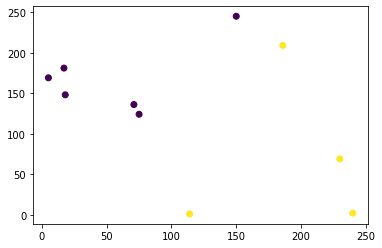

In [46]:
# x_train.shape
# test model on generated dummy dataset 
# data = np.random.randint(255, size = (10, 2))
# data = np.append(data, np.random.choice([0,1],size = (10,1)), axis = 1)
# data.shape

# plt.figure()
# plt.scatter(data[:,0],data[:,1], c = data[:,-1])


In [43]:
# x_train, x_valid

(array([[ 45,  34,   0],
        [ 55, 245,   0],
        [ 38,  45,   1],
        [174, 165,   1],
        [114,  12,   0],
        [191, 123,   0],
        [229, 210,   0],
        [210,  84,   0]]), array([[ 20,  88,   1],
        [ 50, 117,   0]]))

In [47]:
# x_train, x_valid = train_test_split(data, test_size=0.2)

# H_set = FloatBoost(x_train.copy(), x_valid.copy() , 10, 0.05)

learn classifier
error rate is zero


In [51]:
# acc , preds = predict_fboost(H_set, x_train)
# print("Number of classifiers selected (train set):", len(H_set))
# print("Total accuracy %", acc)

Number of classifiers selected (train set): 1
Total accuracy % 100.0


In [52]:
# acc , preds = predict_fboost(H_set, x_valid)
# print("Number of classifiers selected (train set):", len(H_set))
# print("Total accuracy %", acc)

Number of classifiers selected (train set): 1
Total accuracy % 100.0


In [96]:
# # test model on generated dummy dataset 
# data = np.random.randint(255, size = (10, 2))
# data = np.append(data, np.random.choice([-1,1],size = (10,1)), axis = 1)
# data.shape

# plt.figure()
# plt.scatter(data[:,0],data[:,1], c = data[:,-1])

# X_train, X_test = train_test_split(data, test_size=0.2)
# print(X_train.shape)


# H_set = FloatBoost(X_train.copy(), X_test.copy() , 10, 0.005)




# acc , preds = predict_fboost(H_set, X_train)
# print("Number of classifiers selected (train set):", len(H_set))
# print("Total accuracy %", acc)

# plt.figure()
# plt.scatter(X_train[:,0],X_train[:,1], c = preds)
# plt.title("Predicted Classes")

# plt.figure()
# plt.scatter(X_train[:,0],X_train[:,1], c = X_train[:,-1])
# plt.title("Actual Classes")

# acc , preds = predict_fboost(H_set, X_test)
# print("Number of classifiers selected(test set):", len(H_set))
# print("Total accuracy %", acc)

# plt.figure()
# plt.scatter(X_test[:,0],X_test[:,1], c = preds)
# plt.xlim((0,255))
# plt.ylim((-10,255))
# plt.title("Predicted Classes")

# plt.figure()
# plt.scatter(X_test[:,0],X_test[:,1], c = X_test[:,-1])
# plt.xlim((0,255))
# plt.ylim((-10,255))
# plt.title("Actual Classes")




In [ ]:
# # show random images of humans 
# ls = os.listdir("Humans")
# for idx in np.random.randint(len(ls), size = 5):
#   img = cv.imread("Humans/"+ls[idx])
#   img = cv.resize(img, (100,100))
#   cv2_imshow(img)

In [ ]:
# img = cv.imread("Humans/"+ls[0], cv.IMREAD_GRAYSCALE )
# img = cv.resize(img, (20,20))
# integ_img = get_integralimage(img)
# integ_img.min(), integ_img.max(), integ_img.mean()

In [ ]:
# # read images of faces

# ext = ['png', 'jpg'] 
# files = []
# [files.extend(glob.glob('Humans/' + '*.' + e)) for e in ext]
# images = [get_integralimage(cv.resize(cv.imread(file, cv.IMREAD_GRAYSCALE), (20,20))).flatten() for file in files]
# print(len(images), len(images[0]))

In [ ]:
# X = np.append(images, np.ones((len(images), 1)), axis= 1)
# X.shape

In [ ]:
# download images of non-faces


In [ ]:
# #read non-faces images 
# ext = ['png', 'jpg'] 
# files = []
# folders = os.listdir('natural_images')

# [files.extend(glob.glob('natural_images/'+folder+'/' + '*.' + e)) for e in ext for folder in folders]
# images2 = [get_integralimage(cv.resize(cv.imread(file, cv.IMREAD_GRAYSCALE), (20,20))).flatten() for file in files]
# print(len(images2), len(images2[0]))

In [ ]:
# X2 = np.append(images2, np.zeros((len(images2), 1)), axis= 1)
# X2.shape

In [ ]:
# dataset = np.append(X, X2, axis = 0)
# dataset.shape

In [ ]:
# np.random.shuffle(dataset)

In [ ]:
# fig = plt.hist(dataset[:,-1], bins = [-1,1],rwidth=0.5)
# plt.title("distribution of dataset")
# plt.ylabel("# images")
# plt.xlabel("Class")
# plt.xticks([-1,1], ["Non-Face", "Face"])
# print()

In [ ]:
# # random images from non-faces dataset 
# idx = np.random.randint(len(files), size = 5)
# _ = [cv2_imshow(cv.resize(cv.imread(file), (100,100))) for file in np.array(files)[idx]]

In [ ]:
# X_train, X_test = train_test_split(dataset, test_size=0.2)

In [ ]:
# preds = clf.predict(X_test[:,:-1], batch_size = 256)

In [ ]:
# (preds == X_test[:,-1]).mean()

In [ ]:
# preds_train = clf.predict(X_train[:,:-1], batch_size = 256)

In [ ]:
# (preds_train == X_train[:,-1]).mean()

In [ ]:
# H_set = FloatBoost(X_train, 10, 0.005)

In [ ]:
# acc , preds = predict_fboost(H_set, X_train)
# print("Number of classifiers selected (train set):", len(H_set))
# print("Total accuracy %", acc)